# Advanced Machine Learning

# Assigment 10 - Reinforcement Learning

Ana Araújo nº 59457\
Pedro Almeida nº 58844

**Import the necessary packages**

In [ ]:
from datetime import datetime
import random
import gym
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from gym.wrappers.monitoring.video_recorder import VideoRecorder

# random seed
np.random.seed(42)
random.seed(42)

# Problem 1

In order to tackle the Mountain Car challenge (https://gymnasium.farama.org/environments/classic_control/mountain_car/), the purpose of this challenge is to apply the Q-Learning method. The environment is implemented on the widely used OpenAI Gym reinforcement learning framework (https://gymnasium.farama.org/).
In this situation, the agent can only do one of three (zero-indexed) operations to operate the vehicle:
0. Quicken left.
1. Don't speed up.
2. Quicken to the right.



In [ ]:
# "Make" the environment, as in, instantiate an object with an environment of the Mountain Car Problem.
env = gym.make("MountainCar-v0")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


The information about the shape (and contents) of the observation space is stored in the property observation_space. The observations in this case are a cartesian product of the intervals of each dimension because it is a box.

The first dimension in the mountain car issue is the automobile's present location (along the x-axis), which might range from -1.2 to 0.6. The car's current velocity, whose values range from -0.07 to 0.07, makes up the second dimension.

In [ ]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

The next example shows how we may determine the observation space's lower and upper limits for a certain dimension. It is dimension 0 (first) in this case.

In [ ]:
print("Lower bound for first dimension:", env.observation_space.low[0])
print("Upper bound for first dimension:", env.observation_space.high[0])

Lower bound for first dimension: -1.2
Upper bound for first dimension: 0.6


The information about the action space's shape (and contents) is stored in the property action_space. This discrete space has a size of 3, which means it can hold three values.

Action 0 implies accelerate left in the mountain car problem, action 1 means do not accelerate, and action 2 means accelerate right.

In [ ]:
env.action_space

Discrete(3)

**Q-Learning**\
The reinforcement learning algorithm Q-Learning is used to determine the expected cost or reward of an agent's activity in an environment with a certain observed state. A state in the Mountain Problem is a pair of (position, velocity).

Practically, the projected costs or benefits are kept in a structure known as a Q-Table, where a value is assigned to each state and potential course of action within that state.

As the agent investigates its surroundings, it earns incentives that may be utilized to predict future rewards. In this setting, the agent gets rewarded 0 if it is at the objective and -1 if it is not for each action it does.

The agent can either choose a random action at each step, which would be an exploration strategy, or it can use its knowledge to select the action that minimizes cost or maximizes reward based on its Q-Table.

Continuous observation space has been constrained for the Mountain Car problem. Because the location and velocity are continuous, a Q-Table constructed from the cartesian product of the observation dimensions would be almost limitless. It is a bounded space, though, so we can discretize it to create a more manageable Q-Table.

Here is a quick method to discretize them: Round to the nearest integer, multiply location by 10, velocity by 100, then convert to decimals. By increasing the absolute value of the minimal value, shift it to start at 0.

In [ ]:
num_pos = np.round(env.observation_space.high[0] * 10 - env.observation_space.low[0] * 10).astype("int") + 1
print(f"Discretized position observation space: {num_pos}")
num_vel = np.round(env.observation_space.high[1] * 100 - env.observation_space.low[1] * 100).astype("int") + 1
print(f"Discretized velocity observation space: {num_vel}")
print(f"Total states: {num_pos * num_vel * env.action_space.n}")

Discretized position observation space: 19
Discretized velocity observation space: 15
Total states: 855


The original observation space is converted to our discretized space via this aid function. Prior to shifting them to start at 0, we must scale the location by multiplying by 10 and the velocity by 100. We only need to add the absolute lower bound value to do this!
The Q-Table may then be index using these values.

In [ ]:
def get_state_from_observation(env, observation):
    pos, vel = observation
    pos = np.round((pos * 10 + abs(env.observation_space.low[0] * 10))).astype("int")
    vel = np.round((vel * 100 + abs(env.observation_space.low[1] * 100))).astype("int")
    return pos, vel

i) Implement the remaining methods in the auxiliary notebook, which enable the agent to learn from simulation in the environment using Q-Learning.

We initialize the Q-table filling it with zeros. The matrix shape have the next configuration:

In [ ]:
#(19,15,3) q-table shape
def init_qtable(env):
    qtable = np.zeros((19,15,3))  # fill with zeros
    return qtable

In [ ]:
qtable = init_qtable(env)
qtable.shape

(19, 15, 3)

ii) Train an agent with 10.000 episodes and analyze the agents’ learning progression through each episode’s rewards.

Set parameter values

In [ ]:
NUM_EPISODES = 10000
STEPS_PER_EPISODE = 1000
ALPHA = 1
BETA = 1
GAMMA = 0.9
EPSILON_INIT = 1.0
MIN_EPSILON = 0.05
LEARNING_RATE = 0.1 #0.2

We implement the q-learning algorithm with 10000 episodes and 1000 steps per episode.

In [ ]:
env._max_episode_steps = STEPS_PER_EPISODE

Implement the Q-Learning algorithm in the train loop.

In [ ]:
rewards = []

with tqdm(total=NUM_EPISODES, position=0, leave=True) as pbar:
    epsilon = EPSILON_INIT
    for i_episode in range(NUM_EPISODES):
        observation = env.reset()
        pos, vel = get_state_from_observation(env, observation)
        total_rewards = 0.0

        for t in range(STEPS_PER_EPISODE):
            # implemented action
            if(np.random.random() < 1 - epsilon):
                action = np.argmax(qtable[pos, vel])
            else:
                action = np.random.randint(0, env.action_space.n)

            # Take a step in the environment
            observation, reward, done, info = env.step(action)
            # Get new states from new observation
            new_pos, new_vel = get_state_from_observation(env, observation)

            # Implemented q-table update
            if(done and observation[0] >= 0.5):
                qtable[pos, vel, action] = reward
            else:
                qtable[pos, vel, action] = qtable[pos, vel, action] + LEARNING_RATE*(reward + GAMMA*np.max(qtable[new_pos, new_vel, action]) - qtable[pos, vel, action])

            pos, vel = new_pos, new_vel
            total_rewards += reward

            if done:
                break

        # Epsilon Decay
        epsilon = (EPSILON_INIT - MIN_EPSILON) * max((NUM_EPISODES - i_episode) / NUM_EPISODES, 0) + MIN_EPSILON

        rewards.append(total_rewards)
        pbar.update(1)
        pbar.set_postfix({"Mean Rewards (last 100)": np.mean(rewards[-100:]), "Latest Reward": total_rewards, "epsilon": epsilon})

  0%|          | 0/10000 [00:00<?, ?it/s]

Saving Q-table and Rewards:

In [ ]:
now = datetime.now().isoformat()
np.save(f"qtable.npy", qtable)
np.save(f"rewards.npy", np.array(rewards))

iii) Observe its behavior after training by simulating a few episodes.

Loading Q-table and Rewards:

In [ ]:
qtable = np.load("qtable.npy")
rewards = np.load("rewards.npy")

**Episodes Vs. Rewards**

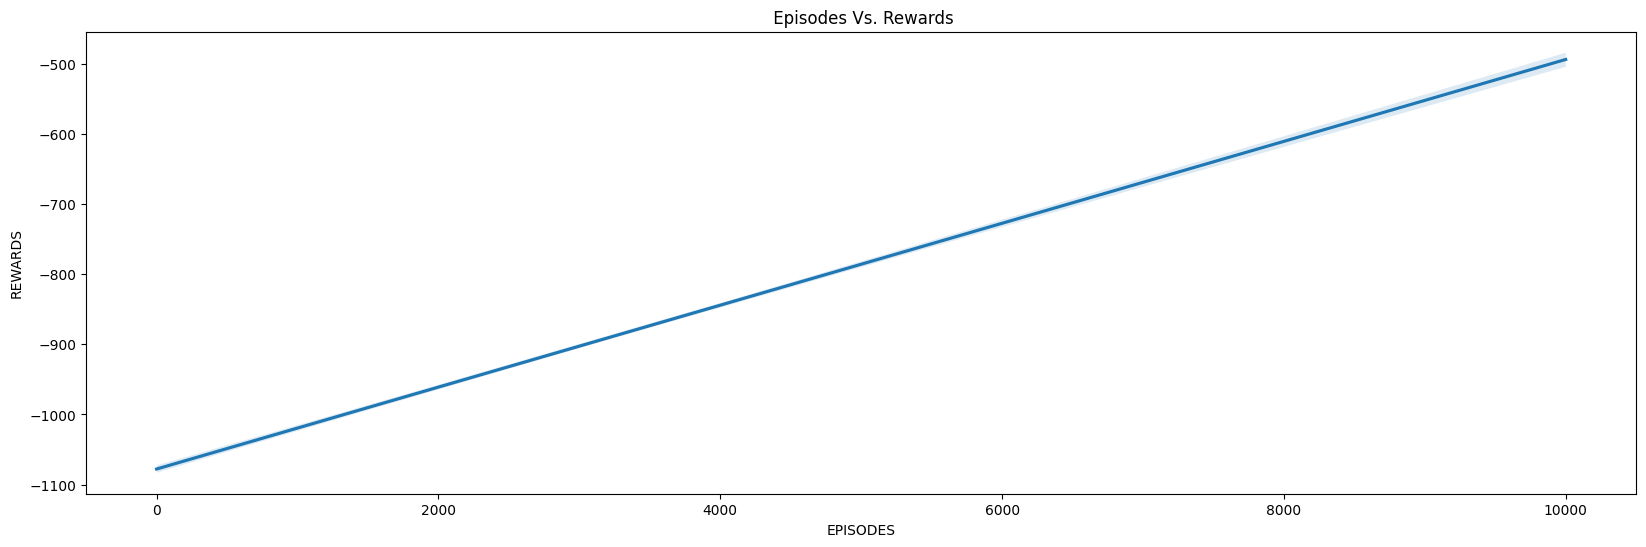

In [ ]:
# linear regression plot
plt.figure(figsize=(20, 6))
reg_plot = sns.regplot(x=list(range(len(rewards))), y=rewards, scatter=False)
reg_plot.set(xlabel='EPISODES', ylabel='REWARDS', title = ' Episodes Vs. Rewards')
plt.show()

The value of rewards rises during the learning process.

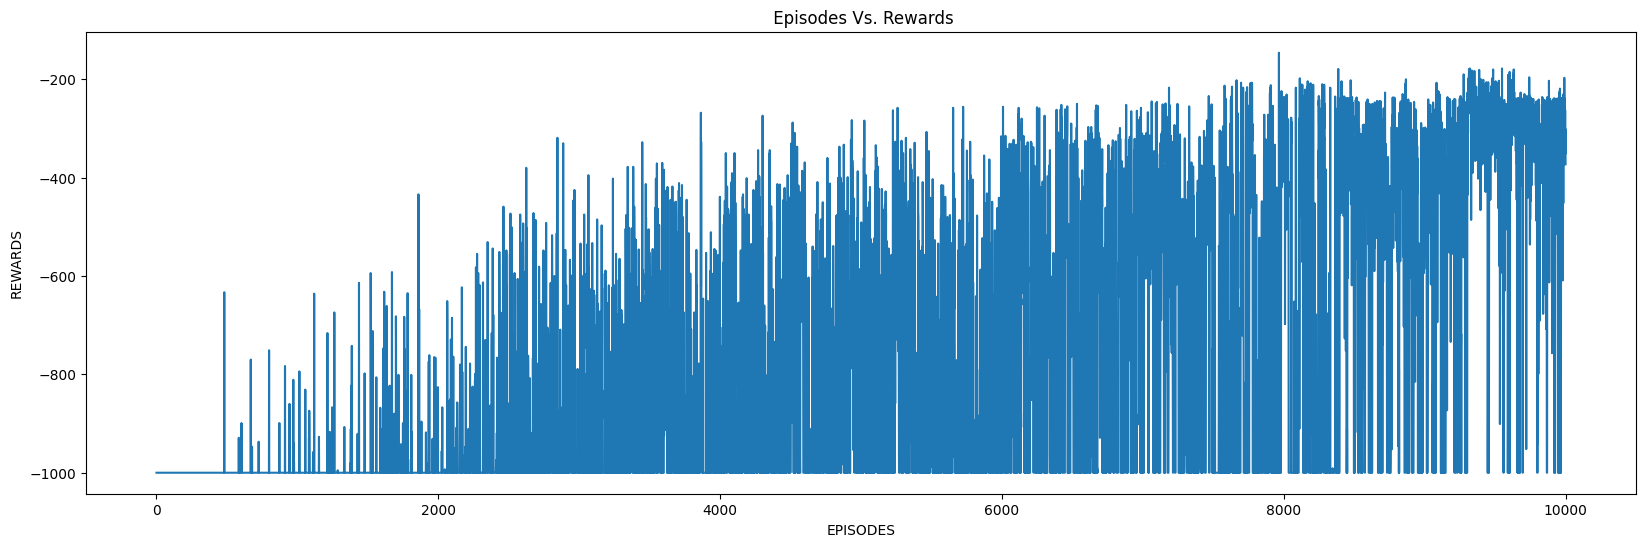

In [ ]:
# line plot
plt.figure(figsize=(20, 6))
line_plot = sns.lineplot(x=list(range(len(rewards))), y=rewards)
line_plot.set(xlabel='EPISODES', ylabel='REWARDS', title = ' Episodes Vs. Rewards')
plt.show()

Throughout the learning process, rewards get more valuable across episodes. It appears like there haven't been much modifications since the ~6500 episode.

## Problem 2


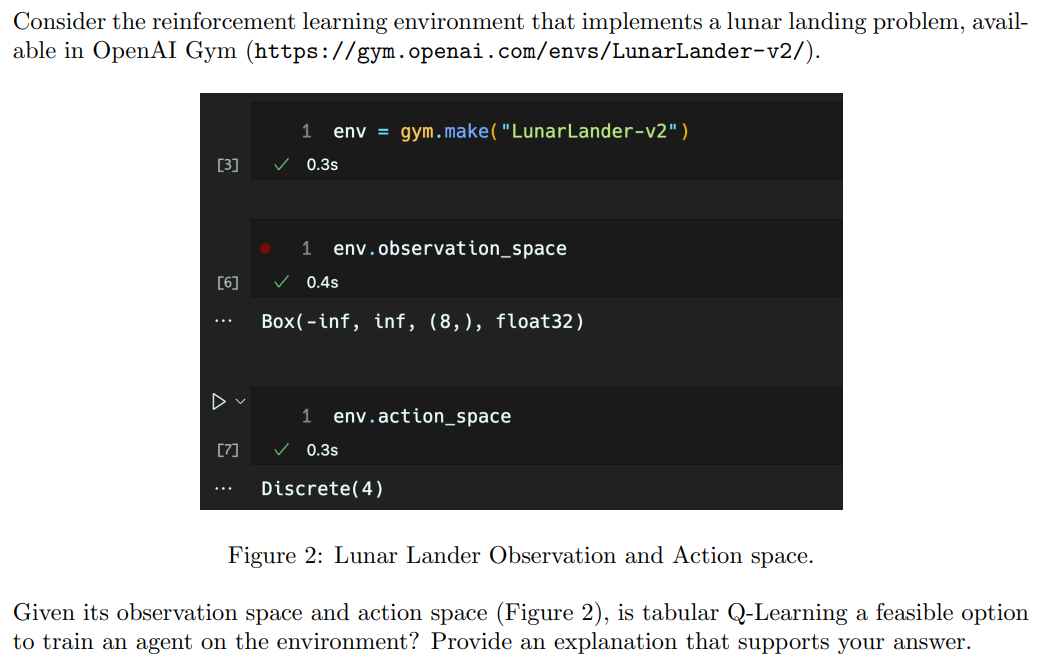


Tabular Q-learning is not a practical choice to train an agent for the Lunar Lander environment given its observation space and action space.

Each state-action pair must have its own entry in the Q-table, which calls for a limited state and action space. The observation space, however, is continuous and infinite in this instance (-infinite, +infinite, (8,)). There are an endless number of potential states as a result of the representation of each state observation as an 8-dimensional vector of float values.

The infinite state space makes it impracticable and wasteful to maintain a separate Q-value for each state-action pair in a tabular form. It would need an abnormally big Q-table, which is impractical to store and update effectively.

When dealing with infinite state spaces, function approximation approaches are frequently used in Q-learning to get past this problem. Deep neural networks with the Q-learning algorithm (DQN) in particular are often used. DQN approximates the Q-function across states by using the expressive capacity of neural networks, which enables generalization and effective representation of the Q-values.

Because the observation space is limitless and continuous, function approximation using a deep neural network and the Q-learning algorithm (DQN) would be a better method for training an agent in the Lunar Lander environment.